<H1> Fitting Bayesian Models


In [25]:
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pymc as pm
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt


<h3>Data Preprocessing

In [26]:
# Load the dataset
insurance_data = pd.read_csv("insurance_claims.csv")

# Display initial information
print(insurance_data.info())
print(insurance_data.head())
#print("Number of values =", insurance_data['incident_severity'].nunique())

# Replace '?' with NaN
insurance_data.replace('?', pd.NA, inplace=True)

# Impute missing values for categorical and numeric columns
for col in insurance_data.select_dtypes(include=['object']).columns:
    insurance_data[col].fillna(insurance_data[col].mode()[0], inplace=True)

for col in insurance_data.select_dtypes(include=['number']).columns:
    insurance_data[col].fillna(insurance_data[col].mean(), inplace=True)

# Binary encoding for binary columns
binary_columns = ['fraud_reported', 'property_damage', 'police_report_available'] # 3
binary_mapping = {'Y': 1, 'N': 0, 'YES': 1, 'NO': 0}
insurance_data.replace(binary_mapping, inplace=True)

# One-hot encoding for multi-class categorical columns
categorical_columns = ['policy_state', 'policy_csl', 'policy_deductable', 'insured_sex', 'insured_relationship',
                       'insured_education_level','incident_type',
                       'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state',
                       'incident_city','auto_make'] #13
insurance_data = pd.get_dummies(insurance_data, columns=categorical_columns, drop_first=False)


# Print new set of columns
insurance_data.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'insured_occupation', 'insured_hobbies', 'capital-gains',
       'capital-loss', 'incident_date', 'incident_location',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_model', 'auto_year',
       'fraud_reported', '_c39', 'policy_state_IL', 'policy_state_IN',
       'policy_state_OH', 'policy_csl_100/300', 'policy_csl_250/500',
       'policy_csl_500/1000', 'policy_deductable_500',
       'policy_deductable_1000', 'policy_deductable_2000',
       'insured_sex_FEMALE', 'insured_sex_MALE',
       'insured_relationship_husband', 'insured_relationship_not-in-family',
       'insured_relationship_other-relative', 'insured_relationship_own-child',
       'in

In [27]:
# Binary code one-hot
# Binary encoding for binary columns
o_binary_columns = [
    'policy_state_IL', 'policy_state_IN',
    'policy_state_OH', 'policy_csl_100/300', 'policy_csl_250/500',
    'policy_csl_500/1000', 'policy_deductable_500',
    'policy_deductable_1000', 'policy_deductable_2000',
    'insured_sex_FEMALE', 'insured_sex_MALE',
    'insured_relationship_husband', 'insured_relationship_not-in-family',
    'insured_relationship_other-relative', 'insured_relationship_own-child',
    'insured_relationship_unmarried', 'insured_relationship_wife',
    'insured_education_level_Associate', 'insured_education_level_College',
    'insured_education_level_High School', 'insured_education_level_JD',
    'insured_education_level_MD', 'insured_education_level_Masters',
    'insured_education_level_PhD', 'incident_type_Multi-vehicle Collision',
    'incident_type_Parked Car', 'incident_type_Single Vehicle Collision',
    'incident_type_Vehicle Theft', 'collision_type_Front Collision',
    'collision_type_Rear Collision', 'collision_type_Side Collision',
    'incident_severity_Major Damage', 'incident_severity_Minor Damage',
    'incident_severity_Total Loss', 'incident_severity_Trivial Damage',
    'authorities_contacted_Ambulance', 'authorities_contacted_Fire',
    'authorities_contacted_Other', 'authorities_contacted_Police',
    'incident_state_NC', 'incident_state_NY', 'incident_state_OH',
    'incident_state_PA', 'incident_state_SC', 'incident_state_VA',
    'incident_state_WV', 'incident_city_Arlington',
    'incident_city_Columbus', 'incident_city_Hillsdale',
    'incident_city_Northbend', 'incident_city_Northbrook',
    'incident_city_Riverwood', 'incident_city_Springfield',
    'auto_make_Accura', 'auto_make_Audi', 'auto_make_BMW',
    'auto_make_Chevrolet', 'auto_make_Dodge', 'auto_make_Ford',
    'auto_make_Honda', 'auto_make_Jeep', 'auto_make_Mercedes',
    'auto_make_Nissan', 'auto_make_Saab', 'auto_make_Suburu',
    'auto_make_Toyota', 'auto_make_Volkswagen'
    
]

binary_mapping = {True: 1, False: 0}
insurance_data.replace(binary_mapping, inplace=True)
insurance_data[o_binary_columns]

,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,policy_deductable_500,policy_deductable_1000,policy_deductable_2000,insured_sex_FEMALE,...,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,1,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
996,1,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
997,0,0,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
998,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:

# Standardize numeric columns
numeric_columns = ['age', 'policy_annual_premium', 'incident_hour_of_the_day', 'number_of_vehicles_involved',
                   'bodily_injuries', 'witnesses', 'capital-gains', 'capital-loss', 'total_claim_amount'] # 9
scaler = StandardScaler()
insurance_data[numeric_columns] = scaler.fit_transform(insurance_data[numeric_columns])

# Create interaction terms (example)
insurance_data['severity_damage'] = (
    insurance_data['incident_severity_Major Damage'] * insurance_data['property_damage']
)

# Drop irrelevant columns
insurance_data.drop(columns=['policy_number', 'policy_bind_date', 'incident_date',
                             'insured_occupation', 'insured_hobbies','injury_claim',
                             'property_claim', 'vehicle_claim', '_c39',
                             'umbrella_limit', 'auto_model', 'auto_year', 'insured_zip', 'incident_location'], inplace=True) # 14


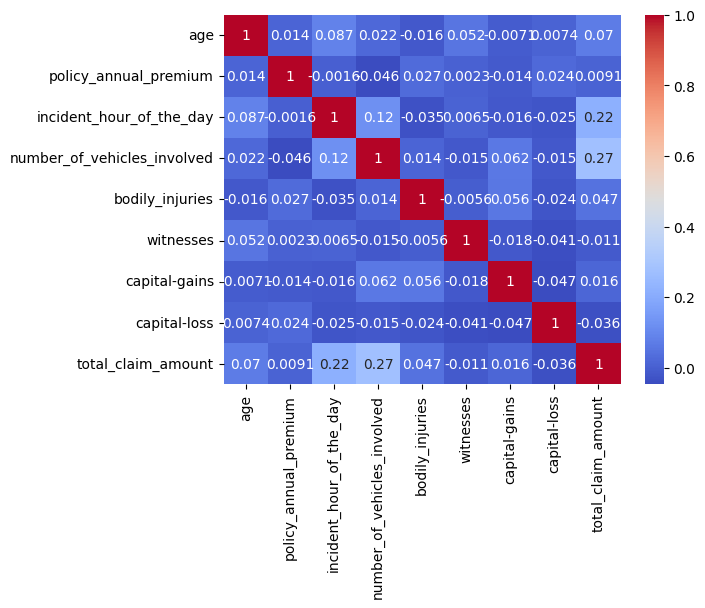

In [29]:
# Correlation Matrix
# Compute correlation matrix
correlation_matrix = insurance_data[numeric_columns].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [30]:
# Split dataset

# Define target and predictors
target = 'fraud_reported'
X = insurance_data.drop(columns=[target])
y = insurance_data[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the processed dataset
processed_file_path = "processed_insurance_claims.csv"
insurance_data.to_csv(processed_file_path, index=False)

print("Preprocessing completed and saved to:", processed_file_path)


Preprocessing completed and saved to: processed_insurance_claims.csv


In [31]:
y_test.value_counts() # Check if we have a reasonable division of Y's and N's

fraud_reported
0    145
1     55
Name: count, dtype: int64

In [32]:
# Convert all columns to numeric if possible
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')


In [33]:
X_train = X_train
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [34]:
# Fill missing values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [35]:
print(X_train.dtypes)


months_as_customer         int64
age                      float64
policy_annual_premium    float64
capital-gains            float64
capital-loss             float64
                          ...   
auto_make_Saab             int64
auto_make_Suburu           int64
auto_make_Toyota           int64
auto_make_Volkswagen       int64
severity_damage            int64
Length: 80, dtype: object


<h2>Model 1: Bayesian Logistic Regression

In [36]:


# Ensure X_train is numeric and has no missing values
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_train.fillna(0, inplace=True)

# Model One: Simple Bayesian Logistic Regression
with pm.Model() as model_one:
    # Priors for intercept and coefficients
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)  # Intercept
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train.shape[1])  # Coefficients for predictors

    mM = pm.math.dot(X_train.values, betas)
    # Logistic regression model (logit link function)
    logit_p = beta_0 + mM
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))  # Transform to probabilities

    # Likelihood: Observed data follows a Bernoulli distribution
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

    # Sample from the posterior distribution
    trace_one = pm.sample(1000, tune=1000, return_inferencedata=True)

# Print model summary
print(az.summary(trace_one, hdi_prob=0.95))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 216 seconds.


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_0   -2.194  1.838    -5.687      1.402      0.036    0.026    2600.0   
betas[0]  0.002  0.002    -0.003      0.006      0.000    0.000    5269.0   
betas[1] -0.181  0.273    -0.728      0.333      0.004    0.004    5304.0   
betas[2] -0.059  0.106    -0.277      0.142      0.001    0.001    7440.0   
betas[3] -0.142  0.108    -0.361      0.065      0.001    0.001    6572.0   
...         ...    ...       ...        ...        ...      ...       ...   
p[795]    0.437  0.183     0.094      0.764      0.003    0.002    4725.0   
p[796]    0.103  0.086     0.003      0.267      0.001    0.001    6702.0   
p[797]    0.050  0.040     0.003      0.127      0.001    0.000    5544.0   
p[798]    0.152  0.115     0.007      0.386      0.002    0.001    5827.0   
p[799]    0.126  0.097     0.006      0.317      0.001    0.001    6098.0   

          ess_tail  r_hat  
beta_0      3077.0    1.0  
betas[0]    3265.0 

In [ ]:
# Print model summary
df_summary = az.summary(trace_one, hdi_prob=0.95)
df_summary.head(20)

881

In [49]:
df_summary[abs(df_summary['mean']) >= 1]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-2.194,1.838,-5.687,1.402,0.036,0.026,2600.0,3077.0,1.0
betas[43],2.333,0.535,1.277,3.344,0.009,0.007,3303.0,2666.0,1.0
betas[46],-1.355,0.656,-2.661,-0.095,0.010,0.007,4662.0,3626.0,1.0


In [115]:
from sklearn.preprocessing import StandardScaler

# Standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [116]:
with pm.Model() as model_one:
    # Tighter priors for intercept and coefficients
    beta_0 = pm.Normal("beta_0", mu=0, sigma=2)  # Intercept
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train_scaled.shape[1])  # Coefficients

    # Logistic regression model
    logit_p = beta_0 + pm.math.dot(X_train_scaled, betas)
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)


In [117]:
# Sample with adjusted NUTS parameters
with model_one:
    trace_one = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.


Sampling: [y_obs]


C:\Users\roshn\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\roshn\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


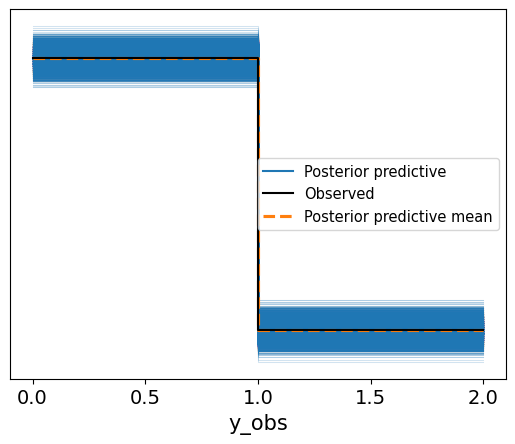

In [38]:
# Posterior predictive checks
with model_one:
    ppc_one = pm.sample_posterior_predictive(trace_one)
    az.plot_ppc(ppc_one)


In [50]:
# Ensure X_test is numeric and has no missing values
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_test.fillna(0, inplace=True)

# Generate predictions using the posterior samples
with model_one:
    # Calculate posterior predictive probabilities for X_test
    posterior_preds = pm.sample_posterior_predictive(trace_one, var_names=["p"], predictions={"p": X_test.values})
    
    # Extract probabilities
    posterior_probs = posterior_preds["p"].mean(axis=0)  # Average probabilities from posterior samples

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
predictions = (posterior_probs >= 0.5).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Calculate additional metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Sampling: []


KeyError: 'p'

In [72]:
posterior_preds["p"]

KeyError: 'p'

In [76]:
#Test model

# Extract posterior samples of beta_0 and betas from the trace
beta_0_samples = trace_one.posterior["beta_0"].values.flatten()
betas_samples = trace_one.posterior["betas"].values

n_samples = len(beta_0_samples)  # Number of posterior samples for beta_0

# Debugging output: print the shapes of the arrays
print("beta_0_samples shape:", beta_0_samples.shape)
print("betas_samples shape:", betas_samples.shape)
print("nsamples:", n_samples)

# Initialize an array to store predicted probabilities
posterior_probs = []

# Compute predicted probabilities for X_test
for i in range(1000):
    # Compute logit_p for each sample
    
    matrix= np.dot(X_test.values, betas_samples[i, :])
    
    logit_p = beta_0_samples[i] + matrix
    # Apply the sigmoid function to get probabilities
    p_sample = 1 / (1 + np.exp(-logit_p))
    posterior_probs.append(p_sample)

# Convert list to NumPy array and calculate mean predicted probabilities
posterior_probs = np.array(posterior_probs).mean(axis=0)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
predictions = (posterior_probs >= 0.5).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Calculate additional metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


beta_0_samples shape: (4000,)
betas_samples shape: (4, 1000, 80)
nsamples: 4000


ValueError: shapes (200,80) and (1000,80) not aligned: 80 (dim 1) != 1000 (dim 0)

<h2> Model 2: Heirachial Bayesian Logistic Regression

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

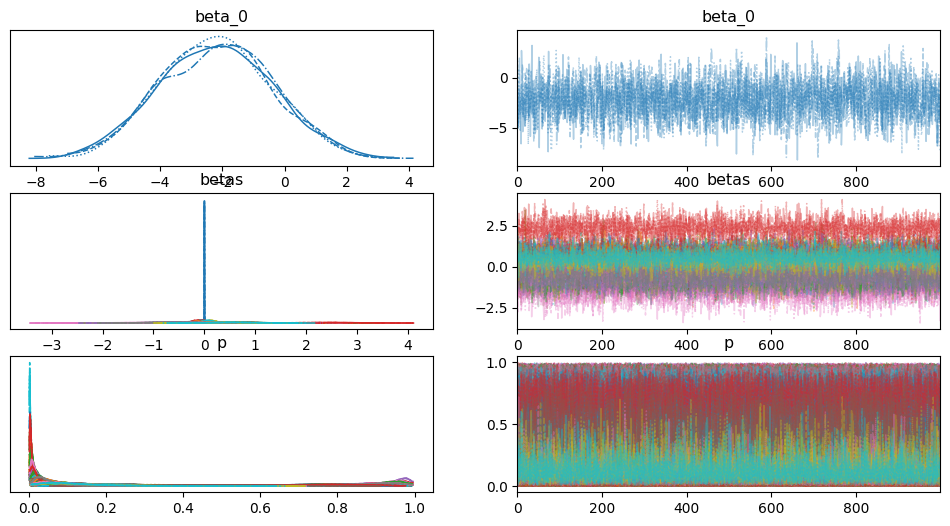

In [39]:

az.plot_trace(trace_one)